# Early Models

This notebook will primarily focus on looking at a collection of simpler models using the combined collisions/traffic flow dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

##### 0. Importing and cleaning the data

In [4]:
## Read in the data with traffic counter and
## bike feature information matched
data_raw = pd.read_csv('./DataFrames/df_road_v3.csv')

In [7]:
data_raw.sample(5)

,ID,total,slight,serious,neigh,Road_name,Road_name2,h,Day_of_Week,m,...,aadf_All_HGVs,aadf_LGVs,aadf_Buses_and_coaches,total_dnorm,total_dnorm_bvnorm,serious_ratio,N_year,Year_start,Year_end,Max_year_gap
415,56869,26,20,6,0,A315,U,16,6,5,...,293.269231,1217.538462,993.807692,21.950773,16.764723,0.230769,22,2000,2021,1
1116,6785,8,8,0,0,A224,U,11,3,5,...,428.500000,2393.875000,124.625000,4.239398,24.771906,0.000000,22,2000,2021,1
1548,17570,3,3,0,0,A217,A217,6,5,11,...,1032.333333,5357.000000,1224.333333,20.032453,3.446391,0.000000,22,2000,2021,1
1485,48768,4,3,1,0,A121,na0,16,3,1,...,1064.000000,3931.250000,220.250000,2.249582,1.712917,0.250000,22,2000,2021,1
81,7671,73,63,10,13,A4200,A4200,9,5,7,...,960.739726,2891.424658,1480.575342,73.870582,10.309962,0.136986,18,2000,2017,1


In [5]:
## Features to ignore when dropping NaN values
## because only the traffic counter data should
## be required to match accident data
bike_features = ['aadf_FEATURE_ID', 'aadf_SVDATE', 'aadf_CLT_CARR', 
                     'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 'aadf_CLT_PARSEG',
                     'aadf_CLT_SHARED', 'aadf_CLT_MANDAT', 'aadf_CLT_ADVIS',
                     'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 'aadf_CLT_BIDIRE',
                     'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 'aadf_CLT_PARKR',
                     'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 'aadf_CLT_ACCESS',
                     'aadf_CLT_COLOUR', 'aadf_BOROUGH']

For now, we will ignore any additional time columns and neighborhood work from Greg because it gets transformed when summing and the mode is taken anyway, making them virtually useless columns.

In [14]:
## Identify potential regression columns
#reg_features = ['Longitude', 'Latitude', 'Day_of_Week',
#                    'Time', 'Road_Type', 'Speed_limit',
#                    'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
#                    'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area',
#                    'aadf_Year', 'aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
#                    'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 
#                    'aadf_CLT_PARSEG', 'aadf_CLT_SHARED', 'aadf_CLT_MANDAT',
#                    'aadf_CLT_ADVIS', 'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 
#                    'aadf_CLT_BIDIRE', 'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 
#                    'aadf_CLT_PARKR', 'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 
#                    'aadf_CLT_ACCESS', 'distance_to_cp']

reg_features = ['aadf_Pedal_cycles', 'aadf_All_motor_vehicles',
                    'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 
                    'aadf_CLT_PARSEG', 'aadf_CLT_SHARED', 'aadf_CLT_MANDAT',
                    'aadf_CLT_ADVIS', 'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 
                    'aadf_CLT_BIDIRE', 'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 
                    'aadf_CLT_PARKR', 'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 
                    'distance_to_cp', 'bikelane']

reg_col = 'total'
class_col = 'Accident_Severity'

In [15]:
data_raw[reg_features]

,Speed_limit,aadf_Pedal_cycles,aadf_All_motor_vehicles,aadf_CLT_CARR,aadf_CLT_SEGREG,aadf_CLT_STEPP,aadf_CLT_PARSEG,aadf_CLT_SHARED,aadf_CLT_MANDAT,aadf_CLT_ADVIS,aadf_CLT_PRIORI,aadf_CLT_CONTRA,aadf_CLT_BIDIRE,aadf_CLT_CBYPAS,aadf_CLT_BBYPAS,aadf_CLT_PARKR,aadf_CLT_WATERR,aadf_CLT_PTIME,distance_to_cp,bikelane
0,30,2435.000000,39430.787671,True,True,True,False,False,False,True,True,False,False,False,True,False,False,False,0.259487,True
1,30,1247.848797,21157.721649,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,0.215577,True
2,30,3585.992188,21983.050781,True,False,False,False,False,True,True,True,False,False,False,False,False,False,False,0.219738,True
3,30,2677.780591,24195.257384,True,True,False,True,True,True,True,True,False,False,False,True,False,False,True,0.267128,True
4,30,2473.373272,17012.562212,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,0.237963,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,-9,138.000000,6714.000000,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,-9.000000,True
4057,-9,10.000000,95.000000,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,-9.000000,True
4058,-9,32.000000,9508.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-9.000000,False
4059,-9,22.000000,190.000000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-9.000000,False


In [92]:
from scipy.stats import moyal
from scipy.optimize import curve_fit

def func(x, loc, scale):
    return moyal.pdf(x, loc, scale)

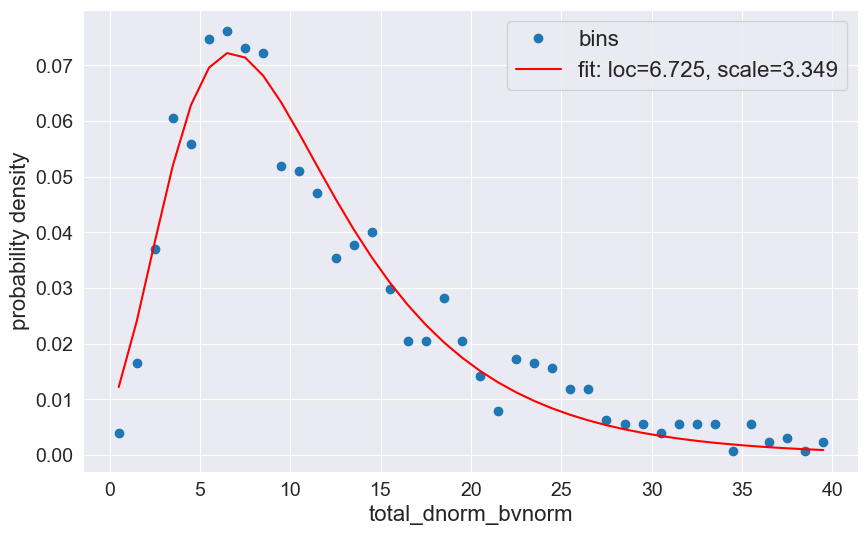

In [100]:
plt.figure(figsize=(10,6))

hist, bins = np.histogram(data_raw.loc[data_raw.total > 5].total_dnorm_bvnorm, bins=40, range=[0,40], density=True)
bins = bins[1:]-0.5

par, cov = curve_fit(func, bins, hist)

plt.plot(bins, hist, 'o',
            label='bins')
plt.plot(bins, moyal.pdf(bins, *par), 'r-',
            label='fit: loc=%5.3f, scale=%5.3f' % tuple(par))

plt.xlabel('total_dnorm_bvnorm', fontsize=16)
plt.ylabel('probability density', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=16)

plt.show()

In [28]:
## import StandardScaler
from sklearn.preprocessing import StandardScaler

In [49]:
## Make a scaler object
scaler = StandardScaler()

## fit the scaler
data_raw[['aadf_Pedal_cycles_scaled', 'aadf_All_motor_vehicles_scaled', 'distance_to_cp_scaled']] = scaler.fit_transform(data_raw[['aadf_Pedal_cycles', 'aadf_All_motor_vehicles', 'distance_to_cp']])

In [50]:
reg_features = ['aadf_Pedal_cycles_scaled', 'aadf_All_motor_vehicles_scaled',
                    'aadf_CLT_CARR', 'aadf_CLT_SEGREG', 'aadf_CLT_STEPP', 
                    'aadf_CLT_PARSEG', 'aadf_CLT_SHARED', 'aadf_CLT_MANDAT',
                    'aadf_CLT_ADVIS', 'aadf_CLT_PRIORI', 'aadf_CLT_CONTRA', 
                    'aadf_CLT_BIDIRE', 'aadf_CLT_CBYPAS', 'aadf_CLT_BBYPAS', 
                    'aadf_CLT_PARKR', 'aadf_CLT_WATERR', 'aadf_CLT_PTIME', 
                    'distance_to_cp_scaled', 'bikelane']

data = data_raw.copy()

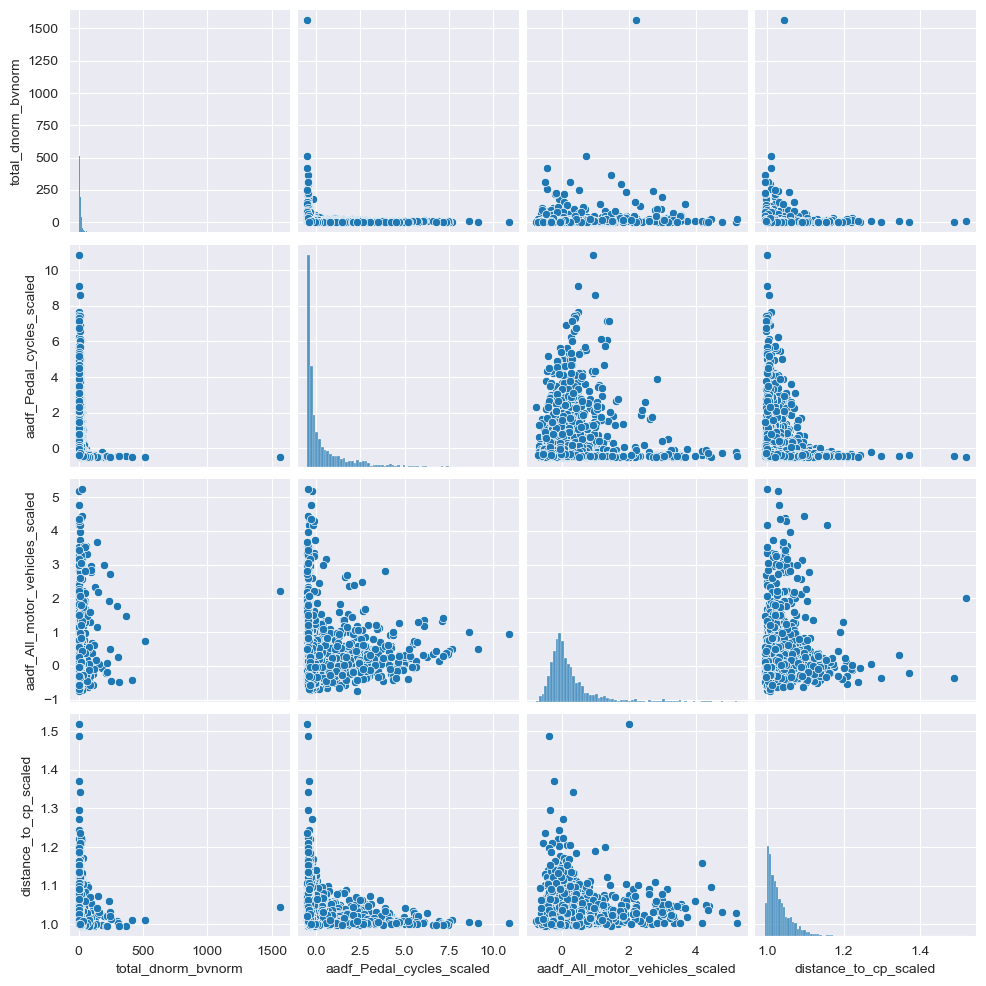

In [107]:
sns.pairplot(data[['total_dnorm_bvnorm', 'aadf_Pedal_cycles_scaled', 'aadf_All_motor_vehicles_scaled', 'distance_to_cp_scaled']])

plt.show()

/Users/bcote/opt/anaconda3/envs/keras_env/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


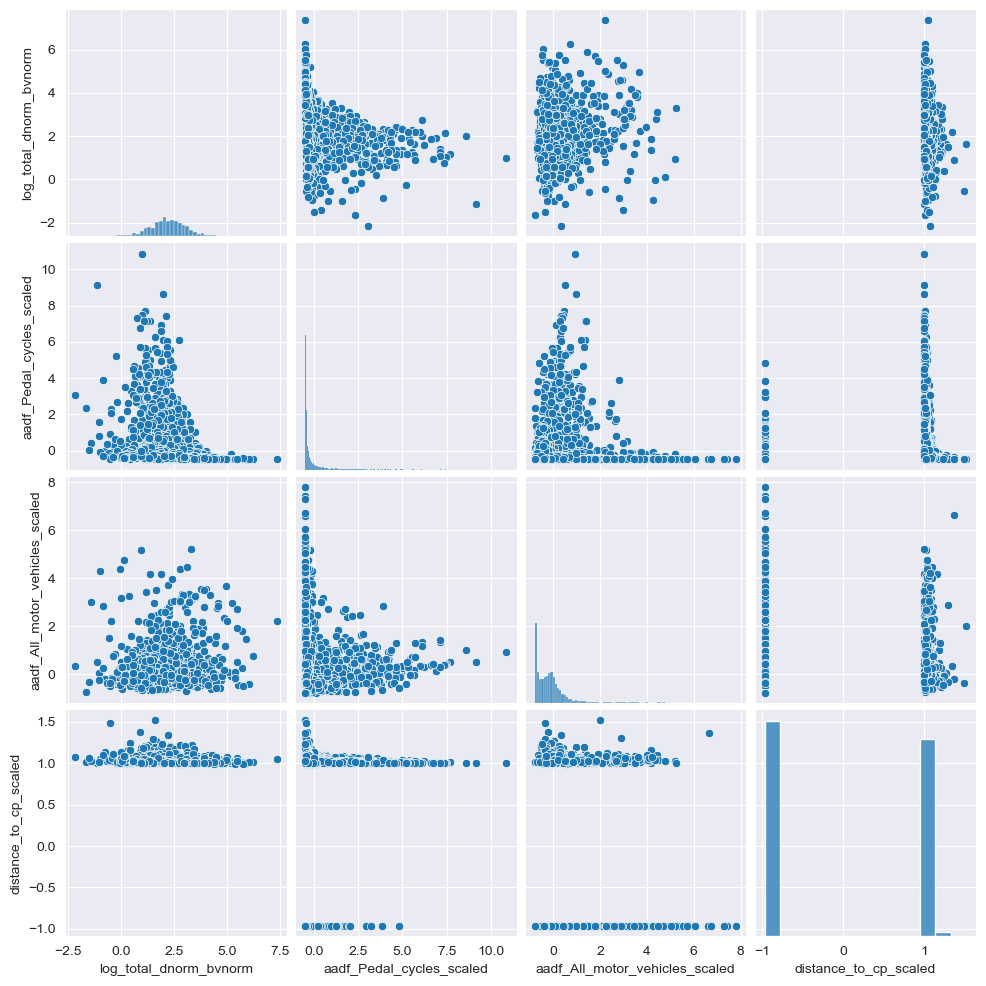

In [109]:
data['log_total_dnorm_bvnorm'] = np.log(data.total_dnorm_bvnorm)
sns.pairplot(data[['log_total_dnorm_bvnorm', 'aadf_Pedal_cycles_scaled', 'aadf_All_motor_vehicles_scaled', 'distance_to_cp_scaled']])

plt.show()

##### 1. Ridge and Lasso Regression

In [39]:
from sklearn.linear_model import Lasso, Ridge

In [110]:
alphas = [0.000001,.00001,.0001,.001,.01,.1,.25,.5,.75,1,5,10,25,50,100,1000,10000]

## make coefficient holder
lasso_coefs = np.zeros((len(alphas), len(reg_features)))
ridge_coefs = np.zeros((len(alphas), len(reg_features)))

# Temporary fix
data.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
data.dropna(inplace=True)

## Loop through alphas
for i in range(len(alphas)):
    ## make lasso model
    lasso = Lasso(alpha=alphas[i], max_iter=10000000)
    ridge = Ridge(alpha=alphas[i], max_iter=10000000)
    
    ## fit model
    lasso.fit(data[reg_features], data.log_total_dnorm_bvnorm)
    ridge.fit(data[reg_features], data.log_total_dnorm_bvnorm)
    
    ## record coefs
    lasso_coefs[i,:] = lasso.coef_
    ridge_coefs[i,:] = ridge.coef_
    

In [111]:
pd.DataFrame(lasso_coefs, index=alphas, columns=reg_features)

,aadf_Pedal_cycles_scaled,aadf_All_motor_vehicles_scaled,aadf_CLT_CARR,aadf_CLT_SEGREG,aadf_CLT_STEPP,aadf_CLT_PARSEG,aadf_CLT_SHARED,aadf_CLT_MANDAT,aadf_CLT_ADVIS,aadf_CLT_PRIORI,aadf_CLT_CONTRA,aadf_CLT_BIDIRE,aadf_CLT_CBYPAS,aadf_CLT_BBYPAS,aadf_CLT_PARKR,aadf_CLT_WATERR,aadf_CLT_PTIME,distance_to_cp_scaled,bikelane
0.000001,-0.273924,0.149268,0.031493,-0.133153,-0.108612,0.016205,-0.103935,-0.141839,-0.025594,0.214737,0.182008,-0.003995,-0.263056,0.326469,-0.082375,-0.294847,0.129828,-5.663381,-0.093002
0.000010,-0.273874,0.149217,0.031304,-0.132987,-0.108179,0.016110,-0.103759,-0.141743,-0.025397,0.214560,0.181855,-0.004114,-0.262358,0.325603,-0.082384,-0.294246,0.129682,-5.656520,-0.092777
0.000100,-0.273381,0.148709,0.029435,-0.131321,-0.103849,0.015149,-0.101949,-0.140773,-0.023408,0.212790,0.180335,-0.005290,-0.255387,0.316946,-0.082476,-0.288241,0.128216,-5.587926,-0.090574
0.001000,-0.268417,0.143627,0.010943,-0.114584,-0.060513,0.005666,-0.083887,-0.131086,-0.003712,0.195036,0.165007,-0.017250,-0.185649,0.230254,-0.083348,-0.228171,0.113391,-4.901268,-0.068440
0.010000,-0.228168,0.101927,0.020445,-0.000000,-0.000000,0.000000,-0.000000,-0.025693,0.000000,0.089915,0.037144,-0.050460,-0.000000,0.000000,-0.025145,-0.000000,0.008750,-0.000000,-0.000000
0.100000,-0.165654,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000
0.250000,-0.077967,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
0.500000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
0.750000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


In [112]:
pd.DataFrame(ridge_coefs, index=alphas, columns=reg_features)

,aadf_Pedal_cycles_scaled,aadf_All_motor_vehicles_scaled,aadf_CLT_CARR,aadf_CLT_SEGREG,aadf_CLT_STEPP,aadf_CLT_PARSEG,aadf_CLT_SHARED,aadf_CLT_MANDAT,aadf_CLT_ADVIS,aadf_CLT_PRIORI,aadf_CLT_CONTRA,aadf_CLT_BIDIRE,aadf_CLT_CBYPAS,aadf_CLT_BBYPAS,aadf_CLT_PARKR,aadf_CLT_WATERR,aadf_CLT_PTIME,distance_to_cp_scaled,bikelane
0.000001,-0.273929,0.149273,0.031513,-0.133172,-0.108660,0.016216,-0.103956,-0.141850,-0.025616,0.214757,0.182025,-0.003982,-0.263133,0.326565,-0.082374,-0.294914,0.129844,-5.664142,-0.093027
0.000010,-0.273929,0.149273,0.031514,-0.133172,-0.108660,0.016216,-0.103955,-0.141850,-0.025616,0.214757,0.182025,-0.003982,-0.263133,0.326565,-0.082374,-0.294913,0.129844,-5.664122,-0.093027
0.000100,-0.273928,0.149273,0.031518,-0.133171,-0.108658,0.016216,-0.103953,-0.141850,-0.025615,0.214755,0.182025,-0.003982,-0.263131,0.326562,-0.082376,-0.294912,0.129844,-5.663924,-0.093028
0.001000,-0.273919,0.149273,0.031560,-0.133162,-0.108644,0.016220,-0.103932,-0.141850,-0.025607,0.214738,0.182030,-0.003981,-0.263109,0.326529,-0.082388,-0.294897,0.129837,-5.661951,-0.093039
0.010000,-0.273830,0.149265,0.031976,-0.133074,-0.108498,0.016258,-0.103722,-0.141850,-0.025527,0.214564,0.182078,-0.003977,-0.262892,0.326197,-0.082508,-0.294750,0.129769,-5.642293,-0.093145
0.100000,-0.272974,0.149188,0.035975,-0.132224,-0.107090,0.016628,-0.101696,-0.141844,-0.024752,0.212892,0.182533,-0.003945,-0.260772,0.322976,-0.083666,-0.293304,0.129117,-5.452964,-0.094156
0.250000,-0.271665,0.149066,0.042045,-0.130908,-0.104920,0.017195,-0.098598,-0.141825,-0.023560,0.210332,0.183205,-0.003920,-0.257436,0.317940,-0.085429,-0.290983,0.128109,-5.164144,-0.095667
0.500000,-0.269758,0.148874,0.050769,-0.128952,-0.101719,0.018021,-0.094090,-0.141772,-0.021807,0.206593,0.184122,-0.003948,-0.252339,0.310329,-0.087977,-0.287329,0.126615,-4.745222,-0.097773
0.750000,-0.268127,0.148695,0.058093,-0.127235,-0.098939,0.018729,-0.090240,-0.141698,-0.020291,0.203386,0.184835,-0.004045,-0.247717,0.303513,-0.090131,-0.283898,0.125308,-4.389136,-0.099468
1.000000,-0.266715,0.148527,0.064312,-0.125710,-0.096491,0.019342,-0.086911,-0.141607,-0.018962,0.200600,0.185388,-0.004195,-0.243478,0.297337,-0.091974,-0.280652,0.124149,-4.082737,-0.100838


##### 2. Linear Regression

In [62]:
from sklearn.linear_model import LinearRegression

In [113]:
slr = LinearRegression(copy_X=True)

slr.fit(data[reg_features], data.log_total_dnorm_bvnorm)

residuals = data.log_total_dnorm_bvnorm - slr.predict(data[reg_features])

In [114]:
residuals

0       0.734539
1       1.203823
2       1.055497
3       0.579971
4       1.017915
          ...   
1955   -2.936771
1956   -1.571259
1957   -0.534913
1959   -1.958907
1960    3.020013
Name: log_total_dnorm_bvnorm, Length: 1932, dtype: float64

##### 3. GridSearchCV

In [55]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [56]:
grid_cv = GridSearchCV(KNeighborsRegressor(), 
                         param_grid = {'n_neighbors':range(1,50),
                                          'weights':['uniform', 'distance']}, 
                         scoring = 'neg_mean_squared_error',
                         cv = KFold(5, shuffle=True, random_state = 30293))

In [115]:
grid_cv.fit(data[reg_features], data.log_total_dnorm_bvnorm)

GridSearchCV(cv=KFold(n_splits=5, random_state=30293, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [116]:
grid_cv.best_params_

{'n_neighbors': 39, 'weights': 'distance'}

In [117]:
grid_cv.best_estimator_.predict(data[reg_features])

array([2.65995018, 3.51043203, 2.30755564, ..., 2.04981386, 0.13460462,
       5.50118585])

In [118]:
grid_cv.best_score_

-0.8144352476062305